# Setup

## Imports


In [ ]:
import functools
import pathlib
import yaml
from yaml import YAMLObject
from typing import *

import attr
from matplotlib import pyplot as plt, cm
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras import losses

In [ ]:
%cd /content/drive/My Drive/segmentation
%load_ext autoreload

In [ ]:
%autoreload 2

import modular_unet
import file_utils
import volume_img_segm
from volume_img_segm import VolumeImgSegmSequence
from logger import logger

## GPUs


In [4]:
%tensorflow_version 2.x
print(f"TensorFlow version: {tf.__version__}")
gpu_device_name = tf.test.gpu_device_name()
if gpu_device_name != "/device:GPU:0":
    raise SystemError("GPU device not found!")
print(f"Found GPU at `{gpu_device_name}`")

TensorFlow version: 2.3.0
Found GPU at `/device:GPU:0`


# Data

## File paths


In [5]:
dir = pathlib.Path("/content/drive/My Drive/segmentation/").absolute()
data_dir = dir / "data"
models_dir = dir / "models"

def _model_path(model_name: str) -> str:
    return models_dir / f"{model_name}"

def _autosaved_model_path(model_name: str) -> str:
    return models_dir / f"{model_name}-autosaved"

def _logger_path(model_name: str) -> str:
    return _model_path(model_name) / "logger.csv"

def _history_path(model_name: str) -> str:
    return _model_path(model_name) / "history.csv"

def _summary_path(model_name: str) -> str:
    return _model_path(model_name) / "summary.txt"

def _architecture_plot_path(model_name: str) -> str:
    return _model_path(model_name) / "architecture.png"

# this is just a little trick to group the 
# filenames in an object and have the auto completion works
class filename:
  train_img_path = data_dir / "tomo.preprocessed.PA66GF30_trans3_x__0_pag.raw"
  train_info_path = data_dir / "tomo.preprocessed.PA66GF30_trans3_x__0_pag.raw.info" 
  train_labels_path = data_dir / "tomo.labels.PA66GF30_trans3_x__0_pag.raw"

  val_img_path = data_dir / "tomo.val.preprocessed.PA66GF30_trans3_x__0_pag.raw"
  val_info_path = data_dir / "tomo.val.preprocessed.PA66GF30_trans3_x__0_pag.raw.info" 
  val_labels_path = data_dir / "tomo.val.labels.PA66GF30_trans3_x__0_pag.raw"

class labels:
  matrix = 0
  fiber = 1
  hole = 2

labels_liste = [0, 1, 2]

dimensions = (500, 500, 500)
dtype = "uint8"

# prefill the function `HST_read`
hst_read = functools.partial(
    file_utils.HST_read,
    autoparse_filename=False,  # the file names are not properly formatted
    data_type=dtype,
    dims=dimensions,
    verbose=True,
)

## Load volumes


In [6]:
train_volume = hst_read(filename.train_img_path)
train_labels = hst_read(filename.train_labels_path)

val_volume = hst_read(filename.val_img_path)
val_labels = hst_read(filename.val_labels_path)

data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0
data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0
data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0
data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0


## Plot slices and labe


In [7]:
def tightsubplots(n, m, w, h):
  fig, axs = plt.subplots(n, m, figsize=(w, h), sharex=True, sharey=True)
  fig.set_tight_layout(True)
  return fig, axs

(-0.5, 499.5, 499.5, -0.5)

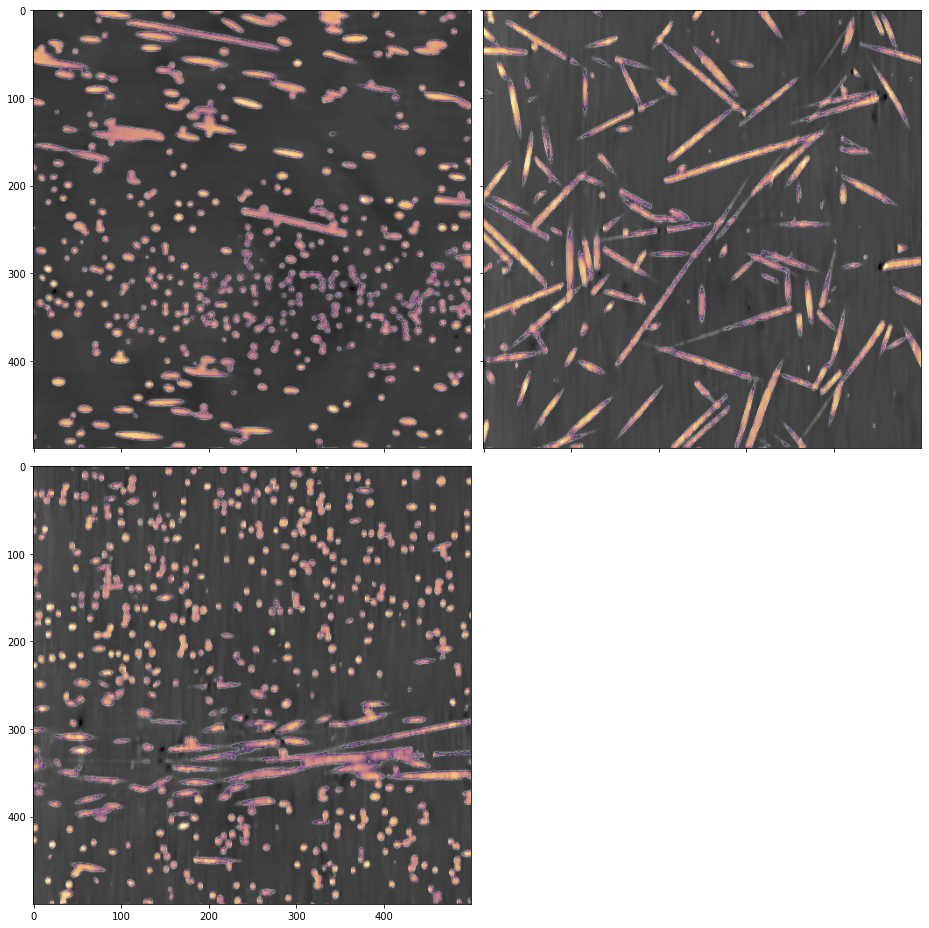

In [8]:
fig, axs = tightsubplots(2, 2, 13, 13)

volume = train_volume
mask = (~ (train_labels == labels.fiber)).astype(int)

axs[0, 0].imshow(volume[:, :, 250], cmap=cm.gray, interpolation=None)
axs[0, 1].imshow(volume[250, :, :], cmap=cm.gray)
axs[1, 0].imshow(volume[:, 250, :], cmap=cm.gray)

volume_masked = np.ma.masked_where(mask, volume)
axs[0, 0].imshow(volume_masked[:, :, 250], cmap=cm.inferno, interpolation=None, alpha=0.5)
axs[0, 1].imshow(volume_masked[250, :, :], cmap=cm.inferno, interpolation=None, alpha=0.5)
axs[1, 0].imshow(volume_masked[:, 250, :], cmap=cm.inferno, interpolation=None, alpha=0.5)

axs[1, 1].axis(False)

## Data Sequences

In [9]:
batch_size = 32
crop_size = 224  # multiple of 16 (requirement of a 4-level u-net)
n_geometric_augmentations = 3  # all
slice_axes = (0, 1, 2,)

train_generator = VolumeImgSegmSequence(
    source_volume=train_volume, 
    label_volume=train_labels,
    labels=labels_liste, 
    axes=slice_axes, 
    batch_size=batch_size,
    shuffle=True,
    normalization_const=255,
    n_geometric_augmentations=n_geometric_augmentations,
    random_state=42,
    crop_size=crop_size,
)

val_generator = VolumeImgSegmSequence(
    source_volume=val_volume, 
    label_volume=val_labels,
    labels=labels_liste, 
    axes=(2,), 
    batch_size=10,
    shuffle=True,
    normalization_const=255,
    n_geometric_augmentations=0,
    random_state=42,
    crop_size=crop_size,
)

# Model

In [10]:
model_name = "dryrun-01"
model_path = _model_path(model_name)
autosave_model_file_path = _autosaved_model_path(model_name)

input_shape = (crop_size, crop_size, 1)
nb_filters_0 = 8
model_generator_function = modular_unet.u_net

In [ ]:
if not autosave_model_file_path.exists():
    assert not model_path.exists()
    model = model_generator_function(input_shape, nb_filters_0=nb_filters_0, output_channels=3, name=model_name)
    model.save(filepath=model_path, overwrite=False)
else:
    logger.warning("An autosaved model already exists, loading it instead of creating a new one!")
    model = keras.models.load_model(autosave_model_file_path)
    

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/segmentation/models/dryrun-01/assets


In [ ]:
def print_to_txt(line, file):
    file.writelines([line + "\n"])

summary_path = _summary_path(model_name)
with open(summary_path, "w") as f:
    model.summary(
        print_fn=functools.partial(print_to_txt, file=f), 
        line_length=140
    )

architecture_figure_path = _architecture_plot_path(model_name)
utils.plot_model(model, show_shapes=True, to_file=architecture_figure_path);

# Compilation

In [11]:
lr = 3e-3
n_epochs = 50
loss_func = losses.categorical_crossentropy

optimizer = optimizers.Adam(lr=lr)

logger_file_path = _logger_path(model_name)
print(autosave_model_file_path, logger_file_path, sep='\n')

cb = [
    callbacks.ModelCheckpoint(
        autosave_model_file_path, 
        monitor="val_loss", 
        verbose=0, 
        save_best_only=True, 
        mode="auto",
    ),
    callbacks.CSVLogger(logger_file_path, separator=",", append=False),
    callbacks.TerminateOnNaN(),
    # ReduceLROnPlateauBacktrack(
    #     model,
    #     autosave_model_file_path,
    #     monitor="val_loss",
    #     factor=0.5,
    #     patience=5,
    #     verbose=1,
    #     mode="auto",
    #     min_delta=0,
    #     min_lr=1e-5,
    # ),
]

/content/drive/My Drive/segmentation/models/dryrun-01-autosaved
/content/drive/My Drive/segmentation/models/dryrun-01/logger.csv


In [ ]:
# unique, counts = np.unique(train_labels, return_counts=True)
# class_freqs = dict(zip(unique, counts))
# total = sum(class_freqs.values())
# class_freqs = {k: v / total for k, v in class_freqs.items()}
# class_freqs
# class_freqs_inv = {k: 1. / v for k, v in class_freqs.items()}
# class_freqs_inv
# import tensorflow as tf
# from tensorflow.python.keras import backend as K
# weights = [class_freqs_inv[i] for i in range(len(class_freqs_inv))]

# def weighted_cross_entropy(y_true, y_pred):
#   Kweights = K.constant(weights)
#   if not K.is_keras_tensor(y_pred):
#     y_pred = K.constant(y_pred)
#   y_true = K.cast(y_true, y_pred.dtype)
#   return K.categorical_crossentropy(y_true, y_pred) * K.sum(y_true * y_pred, axis=-1)

In [ ]:
model.compile(loss=losses.categorical_crossentropy, optimizer=optimizer)
model.save(model_path)

INFO:tensorflow:Assets written to: /content/drive/My Drive/segmentation/models/dryrun-01/assets


# Summary before training

In [ ]:
@attr.s(auto_attribs=True)
class Metadata(YAMLObject):
    yaml_tag = "!Metadata"

    model_name: str = None
    model_path: str = None
    batch_size: Optional[int] = None

    @attr.s(auto_attribs=True)
    class Dataset(YAMLObject):
        yaml_tag = "!Dataset"

        @attr.s(auto_attribs=True)
        class Volume(YAMLObject):
            yaml_tag = "!Volume"
            filename: Optional[str] = None
        
        data: Optional[Volume] = None
        labels: Optional[Volume] = None

        x_shape: Optional[Tuple[int]] = None
        x_dtype: Optional[str] = None

        y_shape: Optional[Tuple[int]] = None
        y_dtype: Optional[str] = None

    train_data: Optional[Dataset] = None
    val_data: Optional[Dataset] = None

    @attr.s(auto_attribs=True)
    class Architecture(YAMLObject):
        yaml_tag = "!Architecture"

        model_generator_function: str = None
        u_net__n_filters_0: int = None
        input_shape: int = None
    
    architecture: Architecture = None

    @attr.s(auto_attribs=True)
    class Training(YAMLObject):
        yaml_tag = "!Training"
        
        autosave_path: str = None
        logger_path: str = None
        n_epochs: int = None
    
    training: Training = None

In [ ]:
train_x, train_y = x, y = train_generator[0]
val_x, val_y = x, y = val_generator[0]

model_experiment = Metadata(
    model_name, str(model_path), batch_size,
    Metadata.Dataset(
        Metadata.Dataset.Volume(str(filename.train_img_path)), 
        Metadata.Dataset.Volume(str(filename.train_labels_path)), 
        str(train_x.shape), train_x.dtype.name, str(train_y.shape), train_y.dtype.name
    ),
    Metadata.Dataset(
        Metadata.Dataset.Volume(str(filename.val_img_path)), 
        Metadata.Dataset.Volume(str(filename.val_labels_path)), 
        str(val_x.shape), val_x.dtype.name, str(val_y.shape), val_y.dtype.name
    ),
    Metadata.Architecture(
        model_generator_function.__name__, nb_filters_0, str(input_shape)
    ),
    Metadata.Training(
        str(autosave_model_file_path), str(logger_file_path), n_epochs
    ),
)

print(yaml.dump(model_experiment))

!Metadata
architecture: !Architecture {input_shape: '(224, 224, 1)', model_generator_function: u_net,
  u_net__n_filters_0: 8}
batch_size: 32
model_name: dryrun-01
model_path: /content/drive/My Drive/segmentation/models/dryrun-01
train_data: !Dataset
  data: !Volume {filename: /content/drive/My Drive/segmentation/data/tomo.preprocessed.PA66GF30_trans3_x__0_pag.raw}
  labels: !Volume {filename: /content/drive/My Drive/segmentation/data/tomo.labels.PA66GF30_trans3_x__0_pag.raw}
  x_dtype: float32
  x_shape: (32, 224, 224, 1)
  y_dtype: float32
  y_shape: (32, 224, 224, 3)
training: !Training {autosave_path: /content/drive/My Drive/segmentation/models/dryrun-01-autosaved,
  logger_path: /content/drive/My Drive/segmentation/models/dryrun-01/logger.csv, n_epochs: 50}
val_data: !Dataset
  data: !Volume {filename: /content/drive/My Drive/segmentation/data/tomo.val.preprocessed.PA66GF30_trans3_x__0_pag.raw}
  labels: !Volume {filename: /content/drive/My Drive/segmentation/data/tomo.val.labels.

# Training


In [12]:
model = tf.keras.models.load_model(autosave_model_file_path)

In [ ]:
history = model.fit(
    x=train_generator,
    validation_data=val_generator,
    validation_steps=20,
    epochs=n_epochs,
    callbacks=cb,
    verbose=1,
    use_multiprocessing=False,
    initial_epoch=15
    # class_weight=class_freqs_inv,  # todo better with actual images !!!!!!!!!!!!!!!!!!!!!
)

[autoreload of tensorflow.python.keras.engine.training failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
tensorflow.python.framework.errors_impl.AlreadyExistsError: Another metric with the same name already exists.
]


Epoch 16/50
562/562 [==============================] - ETA: 0s - loss: 0.0038WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/segmentation/models/dryrun-01-autosaved/assets
562/562 [==============================] - 754s 1s/step - loss: 0.0038 - val_loss: 0.3745
Epoch 17/50
562/562 [==============================] - 744s 1s/step - loss: 0.0036 - val_loss: 0.5566
Epoch 18/50
163/562 [=======>......................] - ETA: 8:44 - loss: 0.0033

In [ ]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 111)

In [ ]:
history_df = pd.DataFrame({**history.history, **{"epochs": history.epoch}})
history_df.to_csv(dir + f"{model_name}-history.csv", index=False)

In [ ]:
model.save(model_path))